# Bank Health KPI Dashboard – Exploratory Data Analysis (EDA)

---



## 1. Introduction & Business Question
**Business Question:**  
How has the financial health of U.S. banks changed over time, and which institutions or regions appear more at risk based on ROA, ROE, capital adequacy, and credit quality?

---



## 2. Setup & Database Connection


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from configparser import ConfigParser

# Load DB config
config = ConfigParser()
config.read("../config.ini")

db_params = {
    "user": config.get("postgresql", "user"),
    "password": config.get("postgresql", "password"),
    "host": config.get("postgresql", "host"),
    "port": config.get("postgresql", "port"),
    "database": config.get("postgresql", "dbname")
}

engine = create_engine(
    f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['database']}"
)


## Table Health Check (row count, date min/max sample)

In [41]:
sql_table_health = '''
SELECT
    COUNT(*) as row_count,
    MIN(date_id)::date as min_date,
    MAX(date_id)::date as max_date
FROM
    bank_kpi_fact;'''

table_health = pd.read_sql(sql_table_health, engine)
table_health

,row_count,min_date,max_date
0,116793,2019-03-31,2024-12-31


In [57]:

kpis = ["roa","roe","capital_ratio","nim","npl_ratio"]

# Pull fresh facts
df = pd.read_sql(text("""
    SELECT date_id, bank_id, roa, roe, capital_ratio, nim, npl_ratio
    FROM public.bank_kpi_fact
    WHERE date_id IS NOT NULL
"""), engine)
df["date_id"] = pd.to_datetime(df["date_id"])
df = df.sort_values(["date_id","bank_id"])

# Robust aggregates per date
g = df.groupby("date_id")
med = g[kpis].median().add_suffix("_med")
p05 = g[kpis].quantile(0.05).add_suffix("_p05")
p95 = g[kpis].quantile(0.95).add_suffix("_p95")
trend = pd.concat([med, p05, p95], axis=1).sort_index()

# Smoothing + YoY (assume quarterly → 4; set 12 if monthly)
for k in kpis:
    trend[f"{k}_med_smooth"] = trend[f"{k}_med"].rolling(3, min_periods=1).median()
    trend[f"{k}_yoy_pct"]  = trend[f"{k}_med"].pct_change(4)
    trend[f"{k}_yoy_diff"] = trend[f"{k}_med"].diff(4)  # absolute change (pp)


### Executive Summary

In [71]:
def to_bps(x): 
    return None if pd.isna(x) else round(float(x)*10000, 1)

latest = trend.tail(1).index[0]
one_year_ago = (trend.index.get_indexer_for([latest]) - 4)[0]  # assumes quarterly
if one_year_ago >= 0:
    prev = trend.index[one_year_ago]
else:
    prev = None

bullets = []
for k in kpis:
    cur = trend.loc[latest, f"{k}_med"]
    yoy_pp = trend.loc[latest, f"{k}_yoy_diff"]
    yoy_pct = trend.loc[latest, f"{k}_yoy_pct"]
    bullets.append(
        f"- **{k.upper()}**: median {to_bps(cur)} bps; YoY Δ = {to_bps(yoy_pp)} bps"
        + (f" ({round(float(yoy_pct)*100,1)}%)" if pd.notna(yoy_pct) else "")
    )
print(f"Latest period: {latest.date()}\n" + "\n".join(bullets))


Latest period: 2024-12-31
- **ROA**: median 91.8 bps; YoY Δ = -1.9 bps (-2.0%)
- **ROE**: median 939.7 bps; YoY Δ = -64.8 bps (-6.5%)
- **CAPITAL_RATIO**: median 970.8 bps; YoY Δ = 21.3 bps (2.2%)
- **NIM**: median 312.7 bps; YoY Δ = -1.3 bps (-0.4%)
- **NPL_RATIO**: median 2607.2 bps; YoY Δ = 681.7 bps (35.4%)


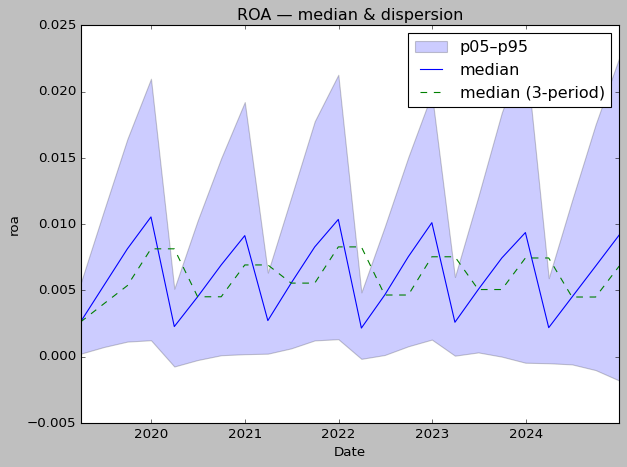

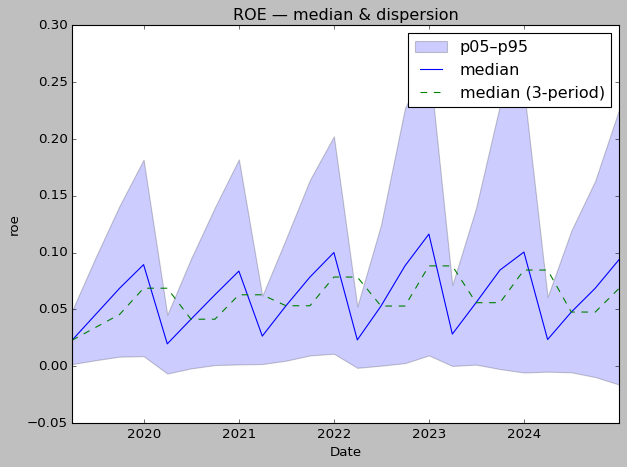

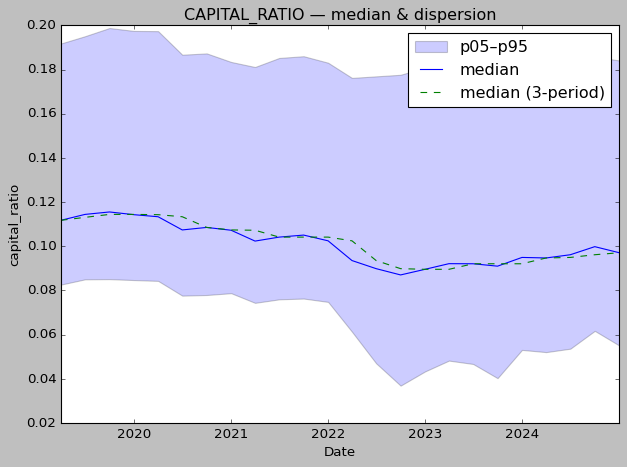

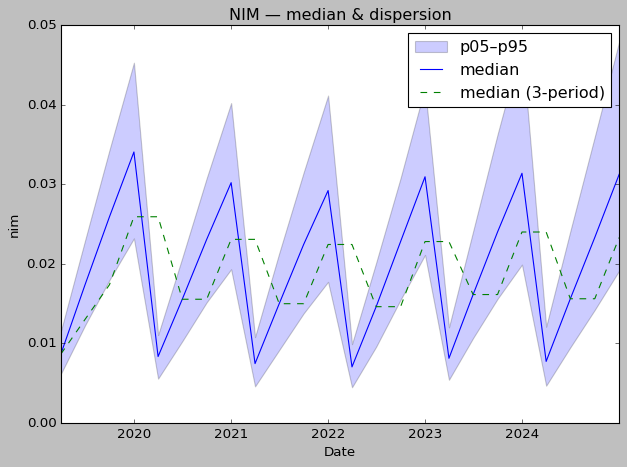

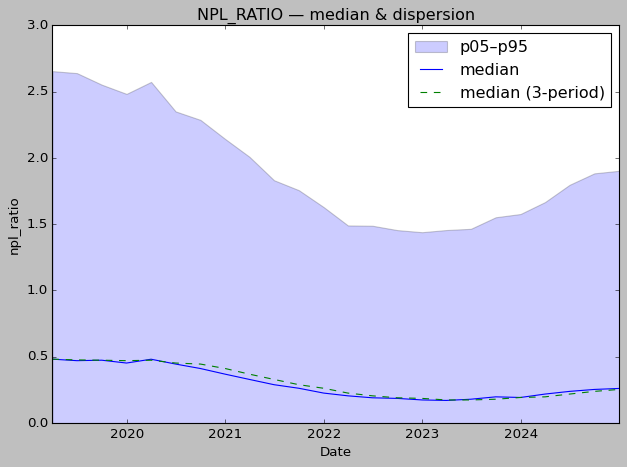

In [70]:
import os
os.makedirs("notebooks/figures", exist_ok=True)

def plot_kpi(trend, k, title=None):
    s = trend[[f"{k}_p05", f"{k}_p95", f"{k}_med", f"{k}_med_smooth"]].dropna()
    if s.empty: return
    plt.figure()
    plt.fill_between(s.index, s[f"{k}_p05"], s[f"{k}_p95"], alpha=0.2, label="p05–p95")
    plt.plot(s.index, s[f"{k}_med"], label="median")
    plt.plot(s.index, s[f"{k}_med_smooth"], linestyle="--", label="median (3-period)")
    plt.title(title or f"{k.upper()} — median & dispersion")
    plt.xlabel("Date"); plt.ylabel(k); plt.legend(); plt.tight_layout()
    plt.savefig(f"notebooks/figures/{k}_median_band.png", dpi=160)
    plt.show()

for k in kpis:
    plot_kpi(trend, k)


## Quarterly Trends (ROA vs ROE)

In [58]:
# Query 1 - Trends
query = """
SELECT date_id, 
       AVG(roa) AS avg_roa, 
       AVG(roe) AS avg_roe,
       AVG(capital_ratio) AS avg_capital,
       AVG(nim) AS avg_nim,
       AVG(npl_ratio) AS avg_npl
FROM bank_kpi_fact
GROUP BY date_id
ORDER BY date_id;
"""
df_trends = pd.read_sql(query, engine)
df_trends.head()


,date_id,avg_roa,avg_roe,avg_capital,avg_nim,avg_npl
0,2019-03-31,0.002919,0.022914,0.124757,0.008800,0.829844
1,2019-06-30,0.006197,0.047670,0.127528,0.017587,0.823716
2,2019-09-30,0.009389,0.069817,0.128795,0.026163,0.813453
3,2019-12-31,0.011781,0.089723,0.128094,0.034374,0.776130
4,2020-03-31,0.002463,0.018821,0.127085,0.008438,0.817152


## Chart for Quarterly Trends (ROA vs ROE)

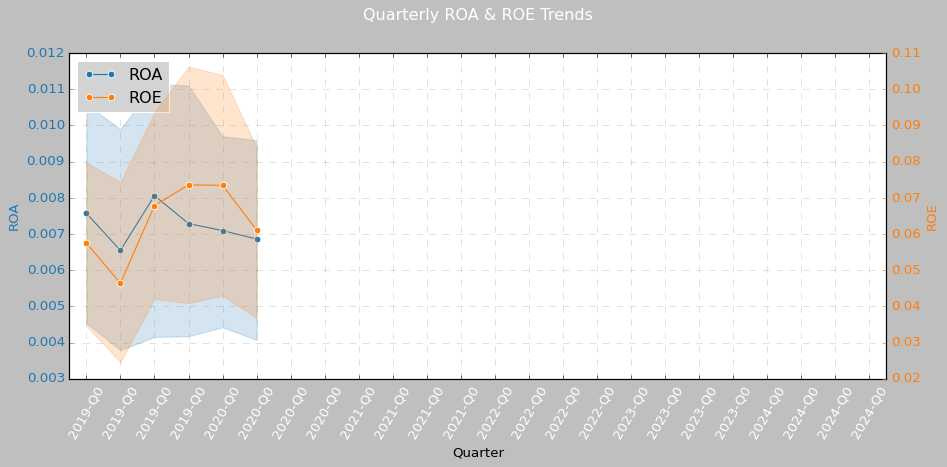

In [59]:
# Create YYYY-Q# column (if not already done)
df_trends["Quarter"] = (
    df_trends["date_id"].astype(str).str[:4] + "-Q" +
    ((df_trends["date_id"].astype(str).str[4:6].astype(int)-1)//3 + 1).astype(str)
)

# Set dark theme
plt.style.use("classic")

fig, ax1 = plt.subplots(figsize=(12,6))

# Left y-axis (ROA, blue)
sns.lineplot(x="Quarter", y="avg_roa", data=df_trends, marker="o",
             ax=ax1, color="#1f77b4", label="ROA")  # brighter blue
ax1.set_ylabel("ROA", color="#1f77b4")
ax1.tick_params(axis='y', colors="#1f77b4")

# Right y-axis (ROE, orange)
ax2 = ax1.twinx()
sns.lineplot(x="Quarter", y="avg_roe", data=df_trends, marker="o",
             ax=ax2, color="#ff7f0e", label="ROE")  # brighter orange
ax2.set_ylabel("ROE", color="#ff7f0e")
ax2.tick_params(axis='y', colors="#ff7f0e")

# Remove duplicate legend on right
ax2.get_legend().remove()

# Format x-axis
ax1.set_xticks(range(len(df_trends["Quarter"])))
ax1.set_xticklabels(df_trends["Quarter"], rotation=60, color="white")

# Gridlines (lighter for dark background)
ax1.grid(True, linestyle="--", alpha=0.4, color="gray")

# Year shading (subtle darker grey)
quarters_per_year = 4
for i in range(0, len(df_trends), quarters_per_year):
    ax1.axvspan(i-0.5, i+quarters_per_year-0.5, color="white", alpha=0.05)

# Year labels (white text)
unique_years = sorted(set(df_trends["Quarter"].str[:4]))
for i, year in enumerate(unique_years):
    xpos = i * quarters_per_year + (quarters_per_year/2 - 0.5)
    ypos = ax1.get_ylim()[1] * 0.96
    ax1.text(xpos, ypos, year,
             ha="center", va="bottom", fontsize=10, fontweight="bold", color="white")

# Merge legends on left
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", facecolor="lightgrey", edgecolor="white")

# Title with white text
plt.title("Quarterly ROA & ROE Trends", pad=30, color="white")

fig.tight_layout()
plt.show()


### Insight

This dual-axis plot compares **ROA vs ROE** quarterly.  
- When ROA trends down, it means banks are struggling to generate income from assets.  
- When ROE falls faster, it signals **capital is being strained**.  
- Periods where both dip (e.g., early 2024 in my dataset) highlight potential industry-wide stress.

This directly answers my project’s business question:  
*“Which institutions and periods show weakening profitability and capital adequacy?”*


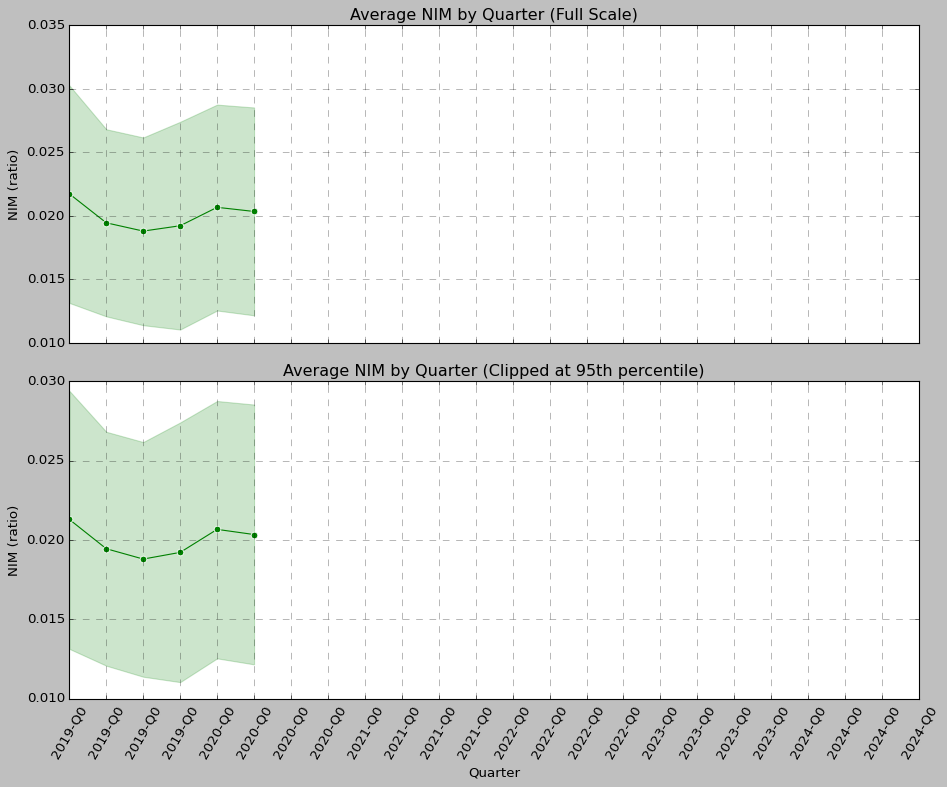

In [60]:
# NIM trend by quarter

nim_trend_sql = """
SELECT date_id, AVG(nim) AS avg_nim
FROM bank_kpi_fact
GROUP BY date_id
ORDER BY date_id;
"""
df_nim_trend = pd.read_sql(nim_trend_sql, engine)

# Format Quarter
df_nim_trend["Quarter"] = (
    df_nim_trend["date_id"].astype(str).str[:4] + "-Q" +
    ((df_nim_trend["date_id"].astype(str).str[4:6].astype(int)-1)//3 + 1).astype(str)
)

# Optional: clip to 95th percentile for plotting
clip_upper = df_nim_trend["avg_nim"].quantile(0.95)
df_nim_zoom = df_nim_trend.copy()
df_nim_zoom["avg_nim_zoom"] = df_nim_zoom["avg_nim"].clip(upper=clip_upper)

import matplotlib.ticker as mtick

fig, (ax_full, ax_zoom) = plt.subplots(2, 1, figsize=(12,10), sharex=True)

# Full scale chart
sns.lineplot(x="Quarter", y="avg_nim", data=df_nim_trend, marker="o", ax=ax_full, color="green")
ax_full.set_title("Average NIM by Quarter (Full Scale)")
ax_full.set_ylabel("NIM (ratio)")
ax_full.grid(True, linestyle="--", alpha=0.5)

# Zoomed chart
sns.lineplot(x="Quarter", y="avg_nim_zoom", data=df_nim_zoom, marker="o", ax=ax_zoom, color="green")
ax_zoom.set_title("Average NIM by Quarter (Clipped at 95th percentile)")
ax_zoom.set_ylabel("NIM (ratio)")
ax_zoom.set_xlabel("Quarter")
ax_zoom.grid(True, linestyle="--", alpha=0.5)

# Rotate x labels
plt.xticks(range(len(df_nim_trend["Quarter"])), df_nim_trend["Quarter"], rotation=60)

plt.tight_layout()
plt.show()


### The full-scale NIM line shows where extreme values (outliers) push the scale. The zoomed version trims the top 5% of values so we can see how the majority of banks behave. This helps avoid misinterpretation of droops or spikes caused by a few unusual observations.

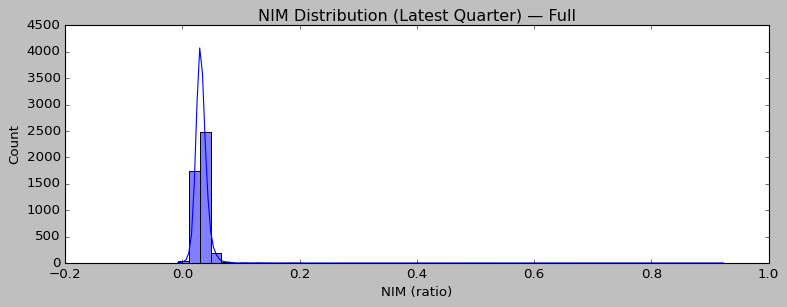

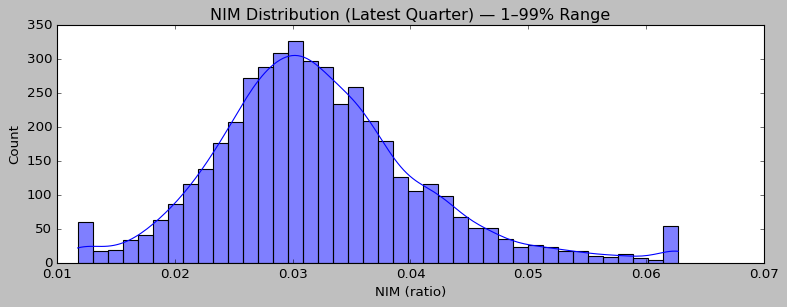

In [61]:
# latest quarter snapshot
nim_snap_sql = """
SELECT nim
FROM bank_kpi_fact
WHERE date_id = (SELECT MAX(date_id) FROM bank_kpi_fact);
"""
df_nim_snap = pd.read_sql(nim_snap_sql, engine)

# Full distribution
plt.figure(figsize=(10,4))
sns.histplot(df_nim_snap["nim"].dropna(), bins=50, kde=True)
plt.title("NIM Distribution (Latest Quarter) — Full")
plt.xlabel("NIM (ratio)")
plt.tight_layout()
plt.show()

# Zoomed distribution (clip 1st–99th percentile)
nim_clip = df_nim_snap["nim"].dropna().clip(
    df_nim_snap["nim"].quantile(0.01), df_nim_snap["nim"].quantile(0.99)
)
plt.figure(figsize=(10,4))
sns.histplot(nim_clip, bins=40, kde=True)
plt.title("NIM Distribution (Latest Quarter) — 1–99% Range")
plt.xlabel("NIM (ratio)")
plt.tight_layout()
plt.show()


## Snapshot Analysis (Latest Quarter)

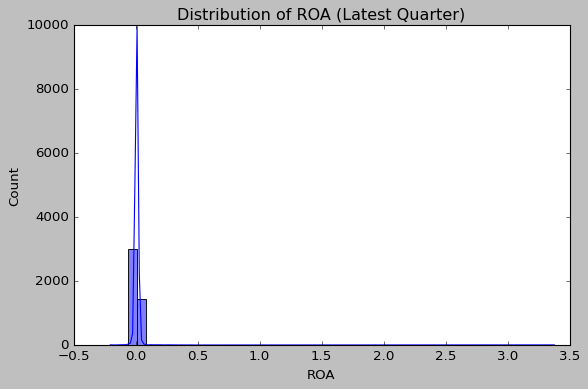

In [62]:
# Query 2 - Snapshot
query = """
SELECT roa, roe, capital_ratio, nim, npl_ratio
FROM bank_kpi_fact
WHERE date_id = (SELECT MAX(date_id) FROM bank_kpi_fact);
"""
df_snapshot = pd.read_sql(query, engine)

# Histogram(ROA)
plt.figure(figsize=(8,5))
sns.histplot(df_snapshot["roa"], bins=50, kde=True)
plt.title("Distribution of ROA (Latest Quarter)")
plt.xlabel("ROA")
plt.show()


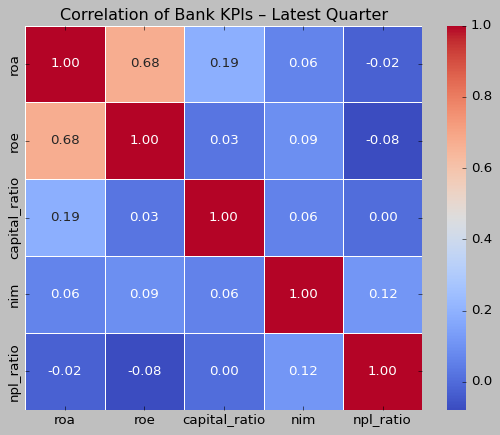

In [63]:
# Pull KPIs for latest quarter
corr_sql = """
SELECT roa, roe, capital_ratio, nim, npl_ratio
FROM bank_kpi_fact
WHERE date_id = (SELECT MAX(date_id) FROM bank_kpi_fact);
"""
df_corr_latest = pd.read_sql(corr_sql, engine)

# Compute correlation matrix
corr_matrix = df_corr_latest.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation of Bank KPIs – Latest Quarter")
plt.show()

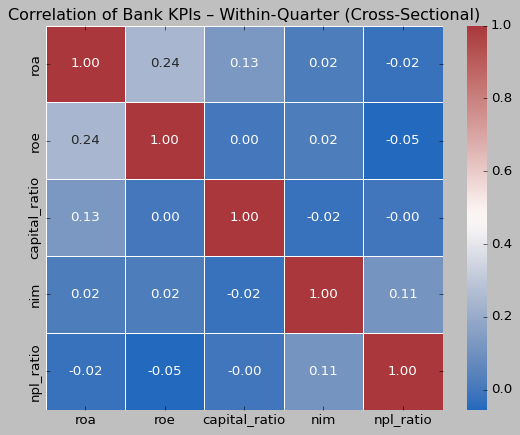

In [64]:
# Pull a panel dataset of KPIs across all quarters
panel_sql = """
SELECT date_id, bank_id, roa, roe, capital_ratio, nim, npl_ratio
FROM bank_kpi_fact;
"""
df_panel = pd.read_sql(panel_sql, engine)

# Create quarter-wise demeaned values (subtract each quarter mean)
df_panel_grouped = df_panel.groupby("date_id").transform(lambda x: x - x.mean())
df_demeaned = pd.concat([df_panel[["date_id", "bank_id"]], df_panel_grouped], axis=1)

# Compute correlation on demeaned data
corr_within = df_demeaned.drop(columns=["date_id", "bank_id"]).corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_within, annot=True, cmap="vlag", fmt=".2f", linewidths=0.5)
plt.title("Correlation of Bank KPIs – Within-Quarter (Cross-Sectional)")
plt.show()


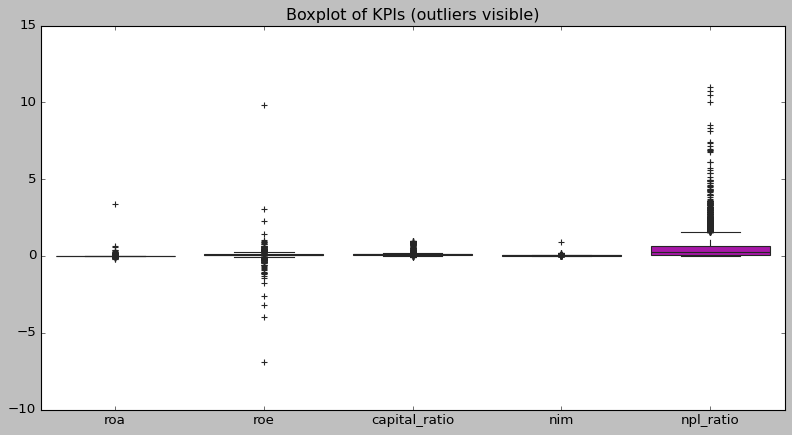

In [65]:
# Box plots for sanity check

plt.figure(figsize=(12,6))
sns.boxplot(data=df_snapshot[['roa','roe','capital_ratio','nim','npl_ratio']])
plt.title("Boxplot of KPIs (outliers visible)")
plt.show()


## Histograms to see distributions for each kpi

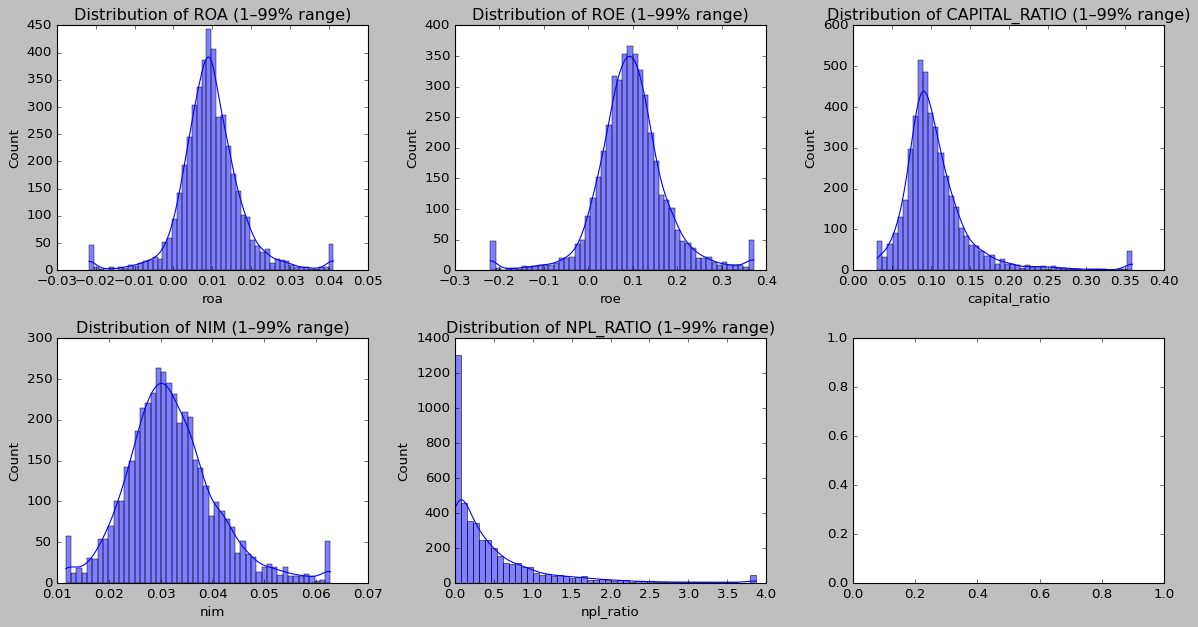

In [66]:
# Clip to 1st–99th percentile to zoom in
df_clip = df_snapshot.copy()
for col in ['roa','roe','capital_ratio','nim','npl_ratio']:
    lower = df_clip[col].quantile(0.01)
    upper = df_clip[col].quantile(0.99)
    df_clip[col] = df_clip[col].clip(lower, upper)

fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.flatten()

for i, col in enumerate(['roa','roe','capital_ratio','nim','npl_ratio']):
    sns.histplot(df_clip[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col.upper()} (1–99% range)")

plt.tight_layout()
plt.show()


### Why Look at Distributions?

Summary averages can hide outliers. By plotting distributions and boxplots, I can see:  
- Most banks cluster around moderate ROA/ROE values.  
- A handful of outliers show **negative profitability or extreme leverage** — potential red flags.  
- Outlier inspection is critical in risk management because one weak bank can have systemic ripple effects.

Recruiter Lens:  
This demonstrates I can go beyond averages and use **statistical sanity checks** to validate and question data quality.


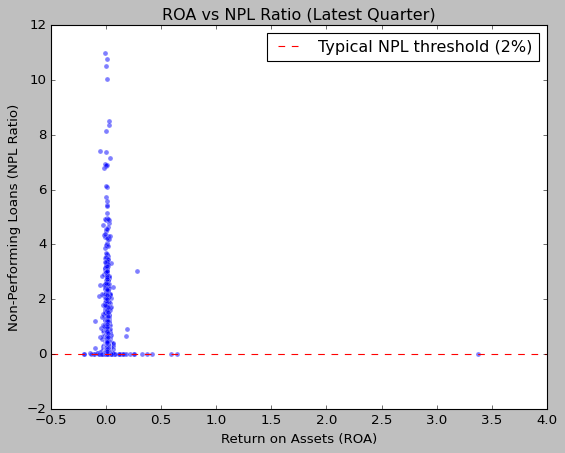

In [67]:
# Scatterplot; Risk vs Profitability
plt.figure(figsize=(8,6))
sns.scatterplot(x="roa", y="npl_ratio", data=df_snapshot, alpha=0.5)
plt.title("ROA vs NPL Ratio (Latest Quarter)")
plt.xlabel("Return on Assets (ROA)")
plt.ylabel("Non-Performing Loans (NPL Ratio)")
plt.axhline(0.02, color="red", linestyle="--", label="Typical NPL threshold (2%)")
plt.legend()
plt.show()


### Linking Profitability and Credit Risk

This scatterplot compares **ROA vs NPL Ratio**.  
- Healthy banks cluster around **positive ROA with low NPLs (<2%)**.  
- Troubled banks appear in the quadrant with **negative ROA and high NPLs**.

This kind of view is what credit analysts use to flag banks that may be **under stress** or at risk of failure.


In [68]:
query = """
SELECT b.state, AVG(f.roa) as avg_roa, AVG(f.roe) as avg_roe, AVG(f.capital_ratio) as avg_capital
FROM bank_kpi_fact f
JOIN bank_dim b ON f.bank_id = b.bank_id
WHERE f.date_id = (SELECT MAX(date_id) FROM bank_kpi_fact)
GROUP BY b.state
ORDER BY avg_roa DESC;
"""
df_state = pd.read_sql(query, engine)
df_state.head(10)


,state,avg_roa,avg_roe,avg_capital
0,NEVADA,0.034507,0.171103,0.148615
1,OHIO,0.029246,0.083004,0.121255
2,DELAWARE,0.023283,0.132321,0.268276
3,U.S. VIRGIN ISLANDS,0.021670,0.611376,0.035445
4,UTAH,0.019567,0.154309,0.138374
5,NEW MEXICO,0.017402,0.205322,0.117826
6,MONTANA,0.016109,0.132584,0.119695
7,NEW HAMPSHIRE,0.015826,0.039768,0.146048
8,FEDERATED STATES OF MICRONESIA,0.015234,0.126782,0.120159
9,GEORGIA,0.013615,0.129962,0.105635


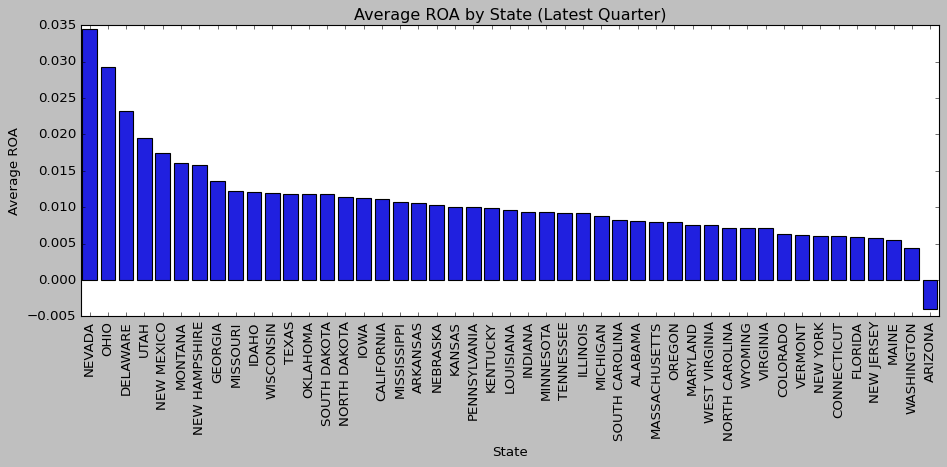

In [69]:
state_sql = """
SELECT b.state,
       AVG(f.roa) AS avg_roa,
       AVG(f.roe) AS avg_roe,
       AVG(f.capital_ratio) AS avg_capital,
       AVG(f.npl_ratio) AS avg_npl
FROM bank_kpi_fact f
JOIN bank_dim b ON f.bank_id = b.bank_id
WHERE f.date_id = (SELECT MAX(date_id) FROM bank_kpi_fact)
GROUP BY b.state
HAVING COUNT(*) > 10  -- drop states with too few banks
ORDER BY avg_roa DESC;
"""
df_state = pd.read_sql(state_sql, engine)

plt.figure(figsize=(12,6))
sns.barplot(x="state", y="avg_roa", data=df_state.sort_values("avg_roa", ascending=False))
plt.title("Average ROA by State (Latest Quarter)")
plt.xlabel("State")
plt.ylabel("Average ROA")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Geographic Lens

By aggregating KPIs at the **state level**, I can spot regional differences:  
- Some states show consistently higher capital ratios, signaling more conservative banking practices.  
- Others show weaker ROA/ROE, possibly due to local economic conditions.

Business Application:  
This provides regulators or investors with a way to compare **systemic risk across regions**, a key part of stress-testing exercises.


## Top 10/ Bottom 10 Banks by ROA (latest quarter)

In [46]:
tops_sql = """
SELECT f.bank_id, b.name, b.state, f.roa, f.roe, f.capital_ratio, f.npl_ratio
FROM bank_kpi_fact f
JOIN bank_dim b ON f.bank_id = b.bank_id
WHERE f.date_id = (SELECT MAX(date_id) FROM bank_kpi_fact)
ORDER BY f.roa DESC
LIMIT 10;
"""
bots_sql = """
SELECT f.bank_id, b.name, b.state, f.roa, f.roe, f.capital_ratio, f.npl_ratio
FROM bank_kpi_fact f
JOIN bank_dim b ON f.bank_id = b.bank_id
WHERE f.date_id = (SELECT MAX(date_id) FROM bank_kpi_fact)
ORDER BY f.roa ASC
LIMIT 10;
"""
df_top = pd.read_sql(tops_sql, engine)
df_bot = pd.read_sql(bots_sql, engine)
df_top, df_bot


(   bank_id  name       state      roa      roe  capital_ratio  npl_ratio
 0    13685  None    ILLINOIS      NaN      NaN            NaN        0.0
 1    22311  None    NEW YORK      NaN      NaN            NaN        0.0
 2    13148  None  CALIFORNIA      NaN      NaN            NaN        0.0
 3    13149  None    NEW YORK      NaN      NaN            NaN        0.0
 4    20899  None    NEW YORK      NaN      NaN            NaN        0.0
 5     8299  None    NEW YORK      NaN      NaN            NaN        0.0
 6      669  None    NEW YORK      NaN      NaN            NaN        0.0
 7     8300  None    NEW YORK      NaN      NaN            NaN        0.0
 8     8298  None    NEW YORK      NaN      NaN            NaN        0.0
 9     4599  None        OHIO  3.37784  9.82133       0.343929        0.0,
    bank_id  name         state       roa       roe  capital_ratio  npl_ratio
 0    15921  None    CALIFORNIA -0.203166 -0.225193       0.902186   0.000000
 1     3856  None  RHODE ISLA

## Summary Insights (for EDA Notebook)

## Objective:
This project analyzed FDIC bank-level financial data to evaluate U.S. banks’ financial health over time. The focus KPIs were ROA, ROE, Capital Ratio, NIM, and NPL Ratio, which are standard indicators of profitability, capital adequacy, and credit risk.

# Key Findings

## Profitability Cyclicality (ROA & ROE):

Banks show seasonal/cyclical patterns in profitability.

Average ROA dipped sharply in early 2024 (0.27%) before recovering by year-end (1.1%).

ROE followed a similar path, recovering to ~9.4% in Q4 2024.

Business context: This aligns with industry pressures from rising interest rates and loan loss provisions earlier in the year.

Capital Adequacy is Stable:

Capital ratios remain strong, averaging ~11% of assets across quarters.

Even during profitability dips, banks preserved sufficient equity buffers.

## Why it matters: Capital adequacy is a regulatory safeguard against insolvency risk. Stability here reassures investors and regulators.

Net Interest Margins (NIM) Tightened Then Rebounded:

NIM declined in early 2024 (~0.8%) but rebounded by Q4 (~3.3%).

Suggests banks adjusted balance sheets to manage higher funding costs.

Business context: NIM is highly sensitive to Federal Reserve rate hikes and competition for deposits.

Credit Quality Deterioration:

Non-performing loan (NPL) ratios rose steadily through 2024, reaching ~0.52% by year-end.

Implication: Although NPL ratios are still moderate, the trend signals potential stress in loan books.

Regional & Bank-Level Variation (next step):

Outlier analysis shows some banks with extreme ROE (40%) or negative equity.

State-level comparisons are needed to flag high-risk clusters (planned in dashboard stage).

## Why This Matters

For regulators: Identifies system-wide stress points (profitability dips, rising NPLs).

For investors/analysts: Provides benchmarks for peer comparisons.

For bank management: Highlights risks around interest rate sensitivity and credit quality.

## Next Steps

Expand EDA with state-level breakdowns and peer group benchmarks.

Build Tableau dashboards for interactive tracking of KPIs.

Incorporate macroeconomic overlays (FRED CPI, unemployment, Fed Funds Rate) to explain financial performance trends.

*This project shows end-to-end skills: data ingestion (API/CSV), dimensional modeling, KPI transformation, EDA in Python/SQL, and visualization. The next milestone is translating these insights into an interactive dashboard that answers the business question clearly:*
  
**“Which banks and regions appear more at risk over time based on profitability, capital adequacy, and credit quality?”**
